# Part I. ETL Pipeline for Pre-Processing the Files

#### Import Python packages 

In [1]:
# Import Python packages 
import pandas as pd
import cassandra
import re
import os
import glob
import numpy as np
import json
import csv

#### Creating list of filepaths to process original event csv data files

In [2]:
# checking current working directory
print(os.getcwd())

# Get current folder and subfolder event data
filepath = os.getcwd() + '/event_data'

# Create a for loop to create a list of files and collect each filepath
for root, dirs, files in os.walk(filepath):
    
# join the file path and roots with the subdirectories using glob
    file_path_list = glob.glob(os.path.join(root,'*'))
    #print(file_path_list)

/home/workspace


#### Processing the files to create the data file csv that will be used for Apache Casssandra tables

In [3]:
# initiating an empty list of rows that will be generated from each file
full_data_rows_list = [] 
    
# for every filepath in the file path list 
for f in file_path_list:

# reading csv file 
    with open(f, 'r', encoding = 'utf8', newline='') as csvfile: 
        # creating a csv reader object 
        csvreader = csv.reader(csvfile) 
        next(csvreader)
        
 # extracting each data row one by one and append it        
        for line in csvreader:
            #print(line)
            full_data_rows_list.append(line) 
            
# uncomment the code below if you would like to get total number of rows 
# print(len(full_data_rows_list))
# uncomment the code below if you would like to check to see what the list of event data rows will look like
#print(full_data_rows_list)

# creating a smaller event data csv file called event_datafile_full csv that will be used to insert data into the \
# Apache Cassandra tables
csv.register_dialect('myDialect', quoting=csv.QUOTE_ALL, skipinitialspace=True)

with open('event_datafile_new.csv', 'w', encoding = 'utf8', newline='') as f:
    writer = csv.writer(f, dialect='myDialect')
    writer.writerow(['artist','firstName','gender','itemInSession','lastName','length',\
                'level','location','sessionId','song','userId'])
    for row in full_data_rows_list:
        if (row[0] == ''):
            continue
        writer.writerow((row[0], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[12], row[13], row[16]))

In [4]:
# check the number of rows in the csv file
with open('event_datafile_new.csv', 'r', encoding = 'utf8') as f:
    print(sum(1 for line in f))

6821


# Part II. Complete the Apache Cassandra coding portion of your project. 

## The event_datafile_new.csv contains the following columns: 
- artist 
- firstName of user
- gender of user
- item number in session
- last name of user
- length of the song
- level (paid or free song)
- location of the user
- sessionId
- song title
- userId

The image below is a screenshot of what the denormalized data should appear like in the **event_datafile_new.csv** after the code above is run:<br>

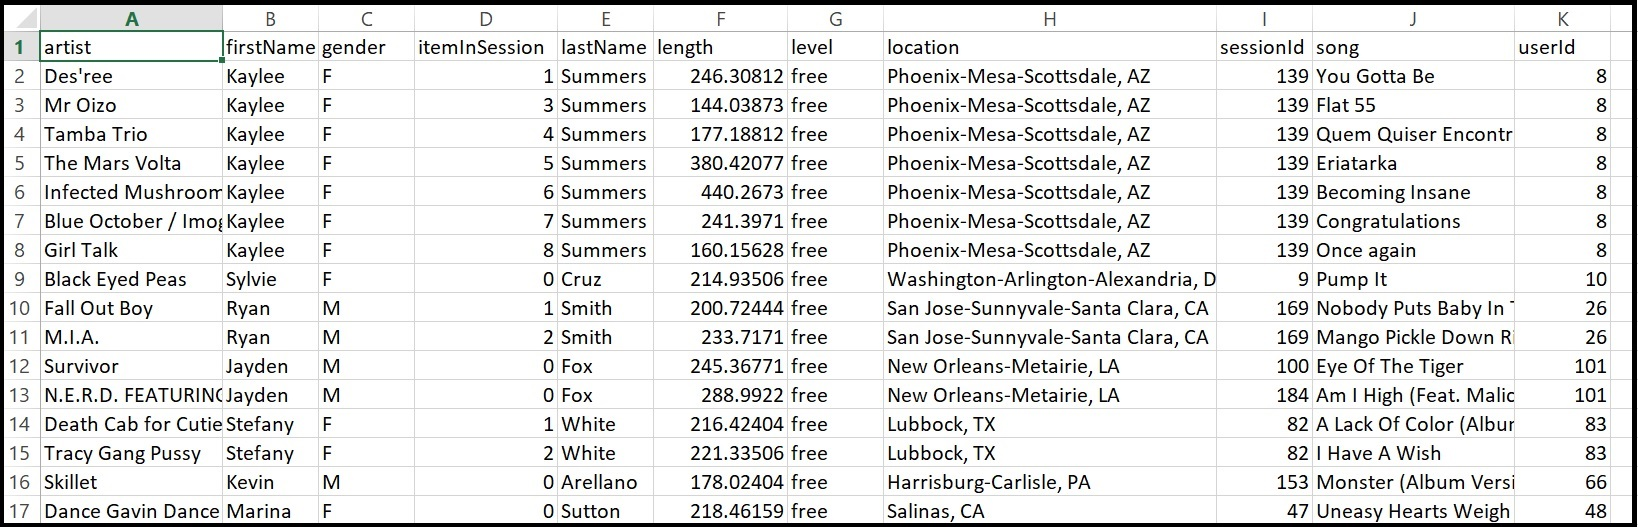

#### Creating a Cluster

In [5]:
# This should make a connection to a Cassandra instance your local machine 
# (127.0.0.1)

from cassandra.cluster import Cluster
cluster = Cluster()

# To establish connection and begin executing queries, need a session
session = cluster.connect()

#### Create Keyspace

In [6]:
try:
    session.execute("""
    CREATE KEYSPACE IF NOT EXISTS sparkify
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }"""
)

except Exception as e:
    print(e)

#### Set Keyspace

In [7]:
try:
    session.set_keyspace('sparkify')
except Exception as e:
    print(e)

## Create queries to ask the following three questions of the data

### 1. Give me the artist, song title and song's length in the music app history that was heard during  sessionId = 338, and itemInSession  = 4

#### 1.1 - Create `songs` table

In [8]:
# use composite (session_id, item_in_session) as unique primary key
# the specified query will filter by the composite key

query = "CREATE TABLE IF NOT EXISTS songs"
query = query + "(session_id INT, \
                  item_in_session INT, \
                  artist_name TEXT, \
                  song_title TEXT, \
                  song_length FLOAT, \
                  PRIMARY KEY (session_id, item_in_session))"
try:
    session.execute(query)
except Exception as e:
    print(e)

#### 1.2 - Insert records into `songs` table

In [9]:
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
        query = "INSERT INTO songs (session_id, item_in_session, artist_name, song_title, song_length)"
        query = query + "VALUES (%s, %s, %s, %s, %s)"
        session.execute(query, (int(line[8]), int(line[3]), line[0], line[9], float(line[5])))

#### 1.3 - Do a SELECT to verify that the data have been inserted the table

In [10]:
query = "SELECT artist_name, song_title, song_length FROM songs WHERE session_id=338 AND item_in_session=4"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print(row.artist_name, row.song_title, row.song_length)

Faithless Music Matters (Mark Knight Dub) 495.30731201171875



### 2. Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182

#### 2.1 - Create `users` table

In [11]:
# use composite (user_id, session_id) as unique Primary Key
# add item_in_session as a clustering column to sort the data

query = "CREATE TABLE IF NOT EXISTS users"
query = query + "(user_id INT, \
                  session_id INT, \
                  item_in_session INT, \
                  artist_name TEXT, \
                  song_title TEXT, \
                  first_name TEXT, \
                  last_name TEXT, \
                  PRIMARY KEY ((user_id, session_id), item_in_session))"
try:
    session.execute(query)
except Exception as e:
    print(e)       

#### 2.2 - Insert records into `users` table

In [12]:
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
        query = "INSERT INTO users (user_id, session_id, item_in_session, artist_name, song_title, first_name, last_name)"
        query = query + "VALUES (%s, %s, %s, %s, %s, %s, %s)"
        session.execute(query, (int(line[10]), int(line[8]), int(line[3]), line[0], line[9],line[1], line[4]))

#### 2.3 - Do a SELECT to verify that the data have been inserted into the table

In [13]:
query = "SELECT artist_name, song_title, first_name, last_name FROM users WHERE user_id=10 AND session_id=182"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print(row.artist_name, row.song_title, row.first_name, row.last_name)

Down To The Bone Keep On Keepin' On Sylvie Cruz
Three Drives Greece 2000 Sylvie Cruz
Sebastien Tellier Kilometer Sylvie Cruz
Lonnie Gordon Catch You Baby (Steve Pitron & Max Sanna Radio Edit) Sylvie Cruz



### 3. Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'

#### 3.1 - Create `user_songplays` table

In [14]:
# song_title was used as a partition key since the queries will filter by this columnn
# add user_id to make up a unique composite primary key (song_title, user_id)

query = "CREATE TABLE IF NOT EXISTS user_songplays"
query = query + "(song_title TEXT, \
                  user_id INT, \
                  first_name TEXT, \
                  last_name TEXT, \
                  PRIMARY KEY (song_title, user_id))"
try:
    session.execute(query)
except Exception as e:
    print(e)       

#### 3.2 - Insert records into `user_songplays` table

In [15]:
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
        query = "INSERT INTO user_songplays (song_title, user_id, first_name, last_name)"
        query = query + "VALUES (%s, %s, %s, %s)"
        session.execute(query, (line[9], int(line[10]), line[1], line[4]))

#### 3.3 - Do a SELECT to verify that the data have been inserted into the table

In [16]:
query = "SELECT first_name, last_name FROM user_songplays WHERE song_title='All Hands Against His Own'"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print(row.first_name, row.last_name)

Jacqueline Lynch
Tegan Levine
Sara Johnson


### Drop the tables before closing out the sessions

In [17]:
## Drop the table before closing out the sessions

try:
    session.execute("DROP TABLE IF EXISTS songs")
    session.execute("DROP TABLE IF EXISTS users")
    session.execute("DROP TABLE IF EXISTS user_songplays")
except Exception as e:
    print(e)

### Close the session and cluster connection¶

In [18]:
session.shutdown()
cluster.shutdown()